# Wisdom of the Tribe -- Model Development (Defining Preference Affinity)
### Justin M. Olds [github.com/jmolds](https://github.com/jmolds)

---
**Project Overview:** The ultimate purpose of this project is to develop a recommendation system for films based the match between a user's film preferences and the preferences of established film critics. This *Wisdom of the Tribes* approach contrasts with *Wisdom of the Masses* approaches provided by many popular websites, such as Metacritic and RottenTomatoes. 

---

**Data:**
* 165,332 critic reviews taken from [metacritic.com](https://www.metacritic.com)
* corresponding to 7689 films
* Reviews were scraped from [metacritic.com](https://www.metacritic.com) based on a list of 19,000 films obtained by scraping search results from [imdb.com](https://www.imdb.com) for the top 500 grossing films (in the US) for every year from 1980 to 2018. 

**Preference Affinity:** 
In this notebook, I showcase how a users film preferences (via ratings for films) are used to identify which film critics have similar preferences. Factor engineering is employed to define preference affinity in the following ways: 
* For a given user film rating (ranging from 0-100), a z-score is defined based on the mean of mean film ratings from critics and the standard deviation (SD) of these means. This is a model assumption that could be updated later using the mean and SD of a particular person's ratings.
* This z-score act's as preference real-estate, so to say, that reviewers can gain if they rated the same film both (1) higher than other reviewers and (2) higher than their mean ratings across all the films they have rated previously. 
* A reviewer's preference affinity is computed by taking the average  of the multipication of a user's rating z-score with the reviewers between-reviewers rating z-score and the multiplication of the same user's rating z-score multiplying with the reviewers within-reviewer rating z-score. 
* After preference affinity values are computed, rating predictions are updated by weighting critic reviews based on thier preference affinity and normalizing these updated ratings to fit between the 0-100 range.

---

**Example user ratings**
Obtained from my aunt over dinner :) 
* On Golden Pond -- 95
* The Green Mile -- 90
* Sausage Party -- 10
* Beaches -- 80
* Field of Dreams -- 96
* Titanic -- 85
* Indiana Jones and the Temple of Doom  -- 90

---




In [1]:
import sqlite3
import pandas as pd
from datetime import datetime
import statistics as stats
import matplotlib.pyplot as plt
import numpy as np
conn = sqlite3.connect("C:/Users/Justin/Desktop/Projects/wisdom-of-the-tribe/data-images-etc/films_and_reviews3.db")
c = conn.cursor()

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': '16',
         'figure.figsize': (12, 8),
         'axes.labelsize': '24',
         'axes.titlesize': '26',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18',
         'grid.linewidth': 2,
         'grid.color': 'white',
         'axes.labelcolor': '.15',
         'axes.edgecolor': '.15',
         'axes.facecolor': '#dee1ec',
         'legend.edgecolor': '0.15',
         'legend.facecolor': 'white',
         'legend.framealpha': 1,
         }
pylab.rcParams.update(params)
#pylab.rcParams.keys()

___
## Updating the database to include values for computing preference affinity

Specifically, I will use the mean and SD for all reviewes for a given film (film_rating_avg, film_rating_sd), and all reviews for a given reviewer (author_rating_avg, author_rating_sd). Additionally, I add columns for computing the preference affinity for each reviewer and create indexes for the id values used for each table. 

In [ ]:
c.execute('ALTER TABLE author ADD review_count INTEGER')
c.execute('ALTER TABLE author ADD author_rating_avg REAL')
c.execute('ALTER TABLE author ADD author_rating_sd REAL')
c.execute('ALTER TABLE author ADD total_score REAL')
c.execute('ALTER TABLE author ADD score_count REAL')
c.execute('ALTER TABLE author ADD pref_aff REAL')
c.execute('ALTER TABLE film ADD film_rating_avg REAL')
c.execute('ALTER TABLE film ADD film_rating_sd REAL')
### create index for film_id and author_id
c.execute('CREATE UNIQUE INDEX idx_film_id ON film (film_id)')
c.execute('CREATE UNIQUE INDEX idx_author_id ON author (author_id)')
c.execute('CREATE UNIQUE INDEX idx_author_film ON review (film_id, author_id)')
c.execute('UPDATE author SET total_score = NULL, score_count = 0, pref_aff = NULL')
conn.commit()    

Below are two loops, one for saving mean ratings for each film and SD into the database and mean ratings for each reviewer and SD. 

In [ ]:
### create loop to generate film_rating_avg & film_rating_sd values 
### same for author: review_count, author_rating_avg, author_rating_sd
##step 1: get all film_id values to build loop
df = pd.read_sql_query("""
    SELECT film_id
    FROM film
""", conn)   
film_ids = df['film_id']
film_ids_tuple = tuple([x for x in df['film_id']]) ## convert to tuple

error_list = list() ##error list to investigate for any failed db updates
for x in film_ids_tuple: 
    c.execute('SELECT rating FROM review INNER JOIN film USING(film_id) WHERE film_id=?', [x])
    individ_film_reviews = c.fetchall()
    temp_ratings_tuple = tuple([x[0] for x in individ_film_reviews])
    try:
        c.execute('UPDATE film SET film_rating_avg= ?, film_rating_sd=? WHERE film_id = ?', 
                  [stats.mean(temp_ratings_tuple), stats.stdev(temp_ratings_tuple), x])
    except:
        error_list.append(x)
        
###author summary stats
df = pd.read_sql_query("""
    SELECT author_id
    FROM author
""", conn)   
author_ids = df['author_id']
author_ids_tuple = tuple([x for x in df['author_id']]) ## convert to tuple


error_list2 = list()
for x in author_ids_tuple: 
    c.execute('SELECT rating FROM review WHERE author_id=?', [x])
    individ_film_reviews = c.fetchall()
    temp_ratings_tuple = tuple([x[0] for x in individ_film_reviews])
    try:
        c.execute('UPDATE author SET author_rating_avg= ?, author_rating_sd=?, review_count = ? WHERE author_id = ?', 
                  [stats.mean(temp_ratings_tuple), stats.stdev(temp_ratings_tuple), len(temp_ratings_tuple), x])
    except:
        error_list2.append(x)

Inspect all attributes for an example film (*Evil Dead II*) to see if values were save correctly:

In [40]:
df = pd.read_sql_query("""
    SELECT *
    FROM review INNER JOIN film USING(film_id) INNER JOIN author USING(author_id)
    WHERE film_title = "Evil Dead II"
""", conn); df

,film_id,author_id,rating,film_title,film_release_date,film_runtime,film_rating_avg,film_rating_sd,first_name,last_name,review_count,author_rating_avg,author_rating_sd,total_score,score_count,pref_aff
0,584,1803,100,Evil Dead II,1987-03-13,84,68.9,22.605063,Jeremy,Zoss,2,85.000000,21.213203,None,None,None
1,584,295,90,Evil Dead II,1987-03-13,84,68.9,22.605063,Kevin,Thomas,1013,66.544916,20.986237,None,None,None
2,584,35,89,Evil Dead II,1987-03-13,84,68.9,22.605063,Marjorie,Baumgarten,1379,56.984772,22.585825,None,None,None
3,584,1804,80,Evil Dead II,1987-03-13,84,68.9,22.605063,Joshua,Klein,27,65.962963,20.848319,None,None,None
4,584,5,75,Evil Dead II,1987-03-13,84,68.9,22.605063,Roger,Ebert,3726,70.141439,21.222088,None,None,None
5,584,25,75,Evil Dead II,1987-03-13,84,68.9,22.605063,Dave,Kehr,614,56.317590,21.022208,None,None,None
6,584,294,50,Evil Dead II,1987-03-13,84,68.9,22.605063,Mike,Clark,966,63.125259,18.944748,None,None,None
7,584,537,50,Evil Dead II,1987-03-13,84,68.9,22.605063,Richard,Harrington,115,49.808696,23.009112,None,None,None
8,584,913,50,Evil Dead II,1987-03-13,84,68.9,22.605063,Caryn,James,99,54.242424,22.636926,None,None,None
9,584,526,30,Evil Dead II,1987-03-13,84,68.9,22.605063,Pat,Graham,41,53.414634,18.042970,None,None,None


Looks good. Next, let's move on to computing the z-scores needed to obtain preference affinity values. 

---
## Computing user rating z-scores for each film (example)

In [ ]:
film_averages = pd.read_sql_query("""
    SELECT film_title, AVG(rating) AS RatingAVG, COUNT(*) as count, film_release_date, film_runtime, film_id
    FROM film INNER JOIN review USING(film_id)
    GROUP BY film_id
""", conn)

User ratings are scaled based on Mean = 58.1 and SD = 15.6
My aunt's rating of 90 for The Green Mile has a z-score of 2.0.



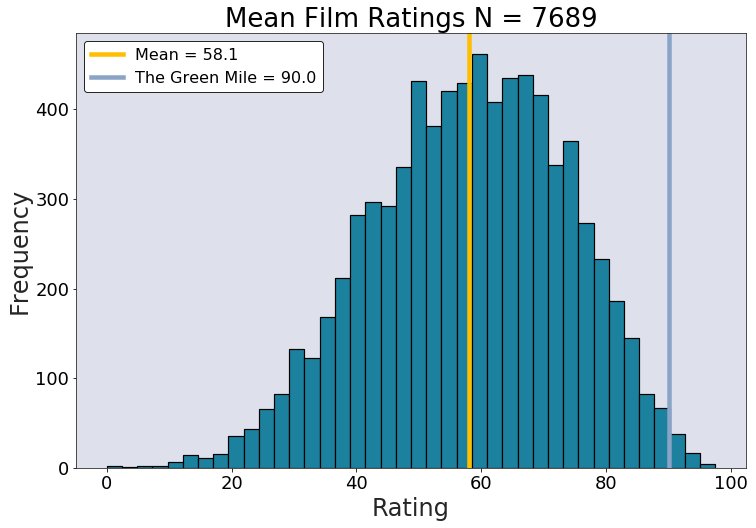

In [119]:
string = 'User ratings are scaled based on Mean = {0:.1f} and SD = {1:.1f}'
mean = stats.mean(film_averages['RatingAVG'])
SD = stats.stdev(film_averages['RatingAVG'])
print(string.format(mean, SD))
z_ex_user = (90-mean)/SD
print("My aunt's rating of 90 for The Green Mile has a z-score of {0:.1f}.\n".format(z_ex_user))
plt.hist(film_averages['RatingAVG'], bins=40, color='#1c819e', edgecolor='black', linewidth=1.2)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Mean Film Ratings N = {}'.format(len(film_averages)))
plt.axvline(x=np.mean(film_averages['RatingAVG']), color="#ffbe00", linewidth=4.5, label='Mean = {0:.1f}'.format(np.mean(film_averages['RatingAVG'])))
plt.axvline(x=90, color="#89a4c7", linewidth=4.5, label='The Green Mile = {0:.1f}'.format(90))
plt.legend()
plt.show()


---
## Computing reviewer rating z-scores for each film--Part 1

Here, I obtain z-scores for a reviewer ratings based on each reviewer's rating compared to other reviewers AND each reviewer's rating compared to all of their other film review ratings. 

For starters, let's see how many reviewers rated *The Green Mile*

**NOTE:** Because the objective of this work is to identify reviewers with similar film preferences as an individual, reviewers with only 1 rating on record were excluded. However, the ratings from these reviewers (many uncredited from the publications) were still used to generate the mean rating and SD for each film (see above).

In [117]:
ex_film = "The Green Mile"
ex_df = pd.read_sql_query("""
    SELECT film_title, film_rating_avg, film_rating_sd, first_name, last_name, rating, review_count, author_rating_avg, author_rating_sd
    FROM review INNER JOIN film USING(film_id) INNER JOIN author USING(author_id)
    WHERE film_title=? AND review_count > 1
    ORDER BY rating DESC
""", conn, params=[ex_film])
print("{} different film critics reviewed The Greem Mile. See below:".format(len(ex_df)))
mean=ex_df['film_rating_avg'][0];SD=ex_df['film_rating_sd'][0]
print("Across all ratings for The Green Mile, Mean = {0:.1f} SD = {1:.1f}".format(mean,SD))
ex_df

36 different film critics reviewed The Greem Mile. See below:
Across all ratings for The Green Mile, Mean = 64.4 SD = 16.1


,film_title,film_rating_avg,film_rating_sd,first_name,last_name,rating,review_count,author_rating_avg,author_rating_sd
0,The Green Mile,64.444444,16.123531,Christopher,Brandon,100,42,65.595238,28.695253
1,The Green Mile,64.444444,16.123531,Andrew,O'Hehir,90,1006,67.696819,21.254500
2,The Green Mile,64.444444,16.123531,Roger,Ebert,88,3726,70.141439,21.222088
3,The Green Mile,64.444444,16.123531,Jonathan,Foreman,88,421,55.470309,19.974441
4,The Green Mile,64.444444,16.123531,Sean,Means,80,110,56.181818,26.852701
5,The Green Mile,64.444444,16.123531,Marc,Savlov,78,1611,50.548727,25.316370
6,The Green Mile,64.444444,16.123531,Jay,Carr,75,854,64.907494,19.345434
7,The Green Mile,64.444444,16.123531,Shawn,Levy,75,1021,70.290891,18.311215
8,The Green Mile,64.444444,16.123531,Lisa,Schwarzbaum,75,1584,67.462753,22.147809
9,The Green Mile,64.444444,16.123531,Rene,Rodriguez,75,1525,62.033443,19.792614


Now let's look at one of the reviewer's that also rated The Green Mile highly and compute their z-score.

    first_name last_name      film_title  rating
0  Christopher   Brandon  The Green Mile     100


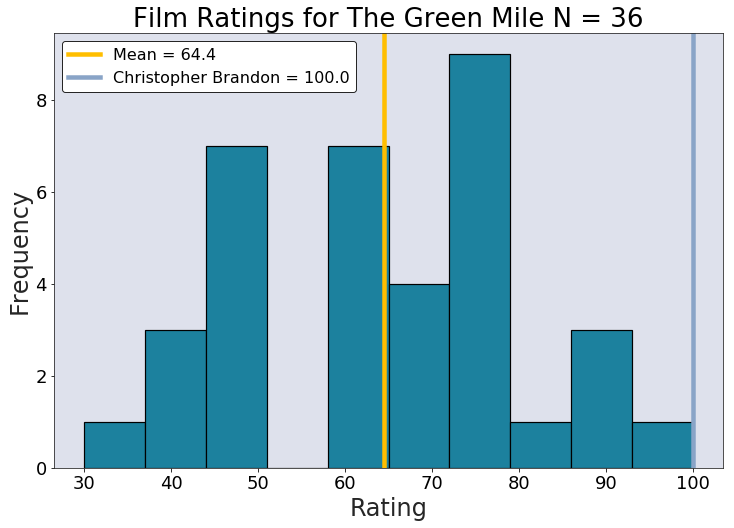

This reviewer's z-score based on all the ratings for the film is 2.2


In [116]:
print(ex_df.loc[[0],['first_name', 'last_name', 'film_title','rating']])
f_name = ex_df.at[0,'first_name']
l_name = ex_df.at[0,'last_name']
rating = ex_df.at[0,'rating']
avg_rating = ex_df.at[0,'film_rating_avg']
plt.hist(ex_df['rating'], color='#1c819e', edgecolor='black', linewidth=1.2)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Film Ratings for The Green Mile N = {}'.format(len(ex_df)))
plt.axvline(x=avg_rating, color="#ffbe00", linewidth=4.5, label='Mean = {0:.1f}'.format(avg_rating))
plt.axvline(x=rating, color="#89a4c7", linewidth=4.5, label='{0} {1} = {2:.1f}'.format(f_name,l_name,rating))
plt.legend()
plt.show()
z_ex_author1 = (rating - avg_rating)/ ex_df.at[0,'film_rating_sd']
print("This reviewer's z-score based on all the ratings for the film is {0:.1f}".format(z_ex_author1))

Before multiplying this reviewer's z-score with the user's z-score to update the reviewer's preference affinity, I will get another z-score based on the reviewer's other ratings and average the two. This will take into account not only if this reviewer liked film more than other, but also if they liked the film more compared to their other ratings. 

---
## Computing reviewer rating z-scores for each film--Part 2
Now we need to get all the other ratings that this particular reviewer has in the database.

In [112]:
ex_df_author = pd.read_sql_query("""
    SELECT film_title, film_rating_avg, film_rating_sd, first_name, last_name, rating, review_count, author_rating_avg, author_rating_sd
    FROM review INNER JOIN film USING(film_id) INNER JOIN author USING(author_id)
    WHERE last_name=? AND first_name = ?
    ORDER BY rating DESC
""", conn, params=[l_name, f_name])
print('{0} {1} reviewed {2} films'.format(f_name,l_name,len(ex_df_author)))
ex_df_author

Christopher Brandon reviewed 42 films


,film_title,film_rating_avg,film_rating_sd,first_name,last_name,rating,review_count,author_rating_avg,author_rating_sd
0,Toy Story 2,88.264706,13.387712,Christopher,Brandon,100,42,65.595238,28.695253
1,The Green Mile,64.444444,16.123531,Christopher,Brandon,100,42,65.595238,28.695253
2,American Beauty,85.515152,16.130563,Christopher,Brandon,100,42,65.595238,28.695253
3,Snow Falling on Cedars,50.333333,18.983356,Christopher,Brandon,95,42,65.595238,28.695253
4,Boiler Room,63.823529,14.953404,Christopher,Brandon,90,42,65.595238,28.695253
5,Life Is Beautiful,65.406250,25.958850,Christopher,Brandon,90,42,65.595238,28.695253
6,American History X,66.062500,19.362314,Christopher,Brandon,90,42,65.595238,28.695253
7,The Matrix,74.171429,14.180529,Christopher,Brandon,90,42,65.595238,28.695253
8,The Blair Witch Project,81.593750,12.520588,Christopher,Brandon,90,42,65.595238,28.695253
9,The Talented Mr. Ripley,78.514286,15.012488,Christopher,Brandon,90,42,65.595238,28.695253


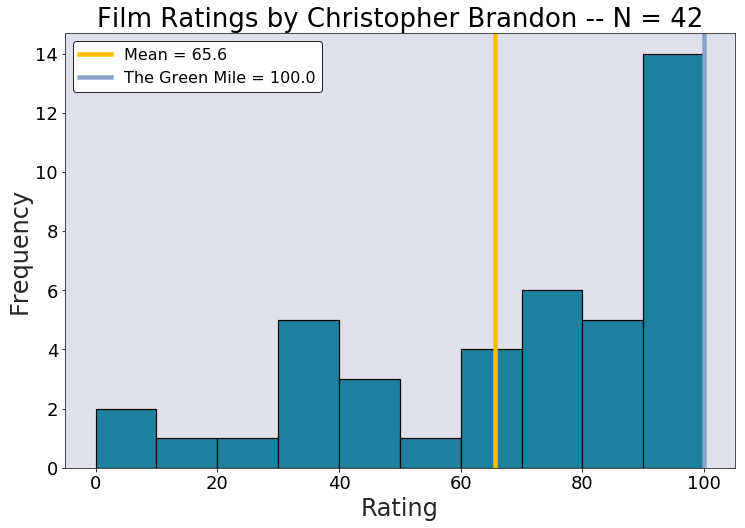

This reviewer's z-score based on all thier other ratings is 1.2


In [118]:
avg_rating_author = ex_df.at[0,'author_rating_avg']
plt.hist(ex_df_author['rating'], color='#1c819e', edgecolor='black', linewidth=1.2)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Film Ratings by {} {} -- N = {}'.format(f_name,l_name,len(ex_df_author)))
plt.axvline(x=avg_rating_author, color="#ffbe00", linewidth=4.5, label='Mean = {0:.1f}'.format(avg_rating_author))
plt.axvline(x=rating, color="#89a4c7", linewidth=4.5, label='{0} = {1:.1f}'.format("The Green Mile",rating))
plt.legend()
plt.show()
z_ex_author2 = (rating - avg_rating_author)/ ex_df.at[0,'author_rating_sd']
print("This reviewer's z-score based on all thier other ratings is {0:.1f}".format(z_ex_author2))

To compute preference affinity, I will use an average of each reviewer's z-scores and multiply it with the user's z-score. 

--- 
## Computing Preference Affinity Example

To account for many films, I will sum the total of preference affinity points scored for each reviewer and divide by the total number of films used to generate the score for each reviewer. However, for the current example I will only be looking at one film (*The Green Mile*). Following this I will account for all the film ratings my aunt gave me. 

In [204]:
z_ex_author = (z_ex_author1+z_ex_author2)/2
print("Reviewer rating z-score for The Green Mile = {0:.1f}".format(z_ex_author))
print("My aunt's rating z-score for The Green Mile = {0:.1f}".format(z_ex_user))
score = z_ex_author*z_ex_user
print("\nAfter multiplying these values together,")
print("the preference affinity points this reviewer has = {0:.1f}".format(score))


Reviewer rating z-score for The Green Mile = 1.7
My aunt's rating z-score for The Green Mile = 2.0

After multiplying these values together,
the preference affinity points this reviewer has = 3.5


Next, let's define a function for looping over all reviewers that rated a given film and update the preference affinity total score and score count values. 

In [367]:
##overall film ratings used to compute user z-scores
overall_film_mean = stats.mean(film_averages['RatingAVG'])
overall_film_sd = stats.stdev(film_averages['RatingAVG'])

def pref_update(film_, rating_):
    ex_df = pd.read_sql_query("""
    SELECT *
    FROM review INNER JOIN film USING(film_id) INNER JOIN author USING(author_id)
    WHERE film_title=? AND review_count > 1
    ORDER BY rating DESC
    """, conn, params=[film_])
    #print('Updating preferences based on {0} Rating = {1}').format(film_,rating_)
    #loop across all author ratings (x) for film 
    for x in range(len(ex_df)):
        user_z = (rating_-overall_film_mean)/overall_film_sd
        by_film_points = user_z * (ex_df['rating'][x]-ex_df['film_rating_avg'][x])/ex_df['film_rating_sd'][x]
        by_author_points = user_z * (ex_df['rating'][x]-ex_df['author_rating_avg'][x])/ex_df['author_rating_sd'][x]
        temp_score = (by_film_points + by_author_points)/2
        ### get total_score from SELECT by author and update + temp_score
        if ex_df['total_score'][x] is not None:
            ex_df.loc[x, 'total_score'] = ex_df.loc[x, 'total_score'] + temp_score
        else: 
            ex_df.loc[x, 'total_score'] = temp_score
        if ex_df['score_count'][x] is not None:
            ex_df.loc[x, 'score_count'] = ex_df.loc[x, 'score_count'] + 1
        else: 
            ex_df.loc[x, 'score_count'] = int(1)
        ex_df.loc[x, 'pref_aff'] = ex_df.loc[x, 'total_score'] / ex_df.loc[x, 'score_count']
        update_total_score = ex_df.at[x, 'total_score']
        update_score_count = ex_df.at[x, 'score_count']
        update_pref_aff = ex_df.at[x, 'pref_aff']
        update_author_id = int(ex_df.at[x, 'author_id'])
        c.execute('''UPDATE author 
                  SET total_score = ?, score_count = ?, pref_aff = ? 
                  WHERE author_id =?''', [update_total_score,update_score_count,update_pref_aff,update_author_id])

Now to update the database with my aunt's rating of 90 for *The Green Mile*.

In [ ]:
print(pref_update("The Green Mile", 90))


Based on only this one rating, let's inspect the distribution of reviewer preference affinity values.

In [372]:
author_df = pd.read_sql_query('''
                SELECT * 
                FROM author
                WHERE pref_aff > 0 OR pref_aff < 0
                ORDER BY pref_aff DESC
                ''', conn)

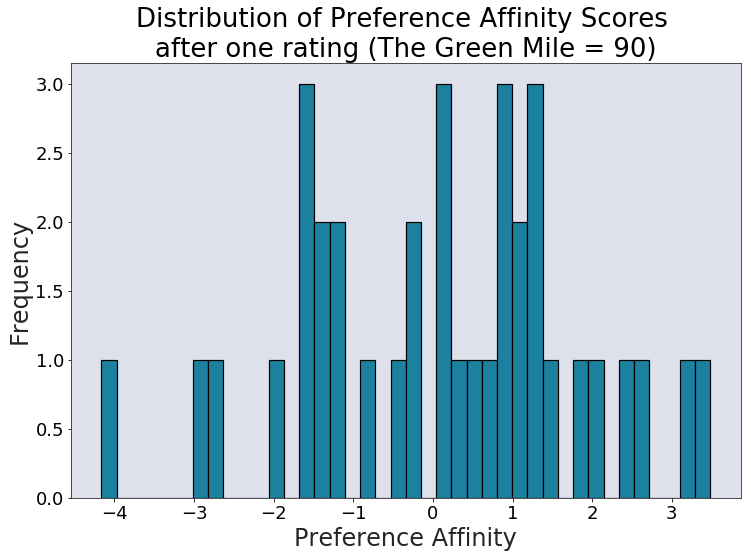

In [373]:
plt.hist(author_df['pref_aff'], bins=40, color='#1c819e', edgecolor='black', linewidth=1.2)
plt.xlabel('Preference Affinity')
plt.ylabel('Frequency')
plt.title("Distribution of Preference Affinity Scores \nafter one rating (The Green Mile = 90)")
plt.show()

Below are all of the the reviewers with updated preference affinity values computed for the above histogram.

In [374]:
print("N = {}".format(len(author_df)))
author_df

N = 36


,author_id,first_name,last_name,review_count,author_rating_avg,author_rating_sd,total_score,score_count,pref_aff
0,1205,Christopher,Brandon,42,65.595238,28.695253,3.481370,1.0,3.481370
1,753,Jonathan,Foreman,421,55.470309,19.974441,3.159575,1.0,3.159575
2,82,Andrew,O'Hehir,1006,67.696819,21.254500,2.694068,1.0,2.694068
3,5,Roger,Ebert,3726,70.141439,21.222088,2.354668,1.0,2.354668
4,120,Marc,Savlov,1611,50.548727,25.316370,1.968718,1.0,1.968718
5,521,Sean,Means,110,56.181818,26.852701,1.893763,1.0,1.893763
6,181,Jami,Bernard,807,60.831475,20.220039,1.386123,1.0,1.386123
7,102,Rene,Rodriguez,1525,62.033443,19.792614,1.339493,1.0,1.339493
8,294,Mike,Clark,966,63.125259,18.944748,1.310539,1.0,1.310539
9,290,Jay,Carr,854,64.907494,19.345434,1.203046,1.0,1.203046


## Tribal ratings
Before updating the preference affinity values based on the other user ratings, let's generate some film predictions based on the tribe we have so far. This entails using the preference affinity values as weights for calculating of a films rating.


In [375]:
### get list of films to update--only ratings from authors with positive preference affinity values
update_df = pd.read_sql_query('''
                SELECT * 
                FROM review INNER JOIN author USING(author_id) INNER JOIN film USING(film_id)
                WHERE pref_aff > 0
                GROUP BY film_id''', conn)
#set index to film_ids
update_df.set_index('film_id', inplace=True, drop=False)
#create tribe rating column
update_df['tribe_rating'] = None
### calc tribe ratings 
for x in update_df['film_id']:
    ##get by film reviews for each tribe member
    temp_df = \
    pd.read_sql_query("""
                      SELECT *
                      FROM review INNER JOIN author USING(author_id) INNER JOIN film USING(film_id)
                      WHERE film_id=? AND pref_aff > 0
                      """, conn, params=[x]) 
    ### normalize pref_aff weights to sum to number of tribe members
    normer = len(temp_df)/sum(temp_df['pref_aff'])
    temp_df['n_pref_aff']= normer * temp_df['pref_aff']
    tribe_rating = sum(temp_df['rating'] * temp_df['n_pref_aff'])/sum(temp_df['n_pref_aff'])
    update_df.loc[x, 'tribe_rating'] = tribe_rating

In [376]:
pd.set_option('display.max_rows', 2000)
update_df.loc[:,['film_title', 'film_release_date', 'film_rating_avg', 'tribe_rating']].sort_values(by="tribe_rating", ascending=False)

,film_title,film_release_date,film_rating_avg,tribe_rating
film_id,,,,
271,Amadeus,2002-04-05,90.545455,100
6150,Amour,2012-12-19,91.136364,100
1,Star Wars: Episode V - The Empire Strikes Back,1980-05-21,83.090909,100
6537,Gimme Shelter (re-release),2000-08-11,85.090909,100
160,Tex,1982-07-30,78.000000,100
165,Personal Best,1982-02-05,74.300000,100
4296,Still Life,2008-01-18,82.300000,100
6474,Inside Llewyn Davis,2013-12-06,91.653846,100
6533,"Bless Me, Ultima",2013-02-22,63.294118,100


Next, let's update the database with the rest of my aunt's ratings.

In [377]:
pref_update("On Golden Pond", 95)
pref_update("Sausage Party", 10)
pref_update("Beaches", 80)
pref_update("Field of Dreams", 96)
pref_update("Titanic", 85)
pref_update("Indiana Jones and the Temple of Doom", 90)

In [379]:
author_df = pd.read_sql_query('''
                SELECT * 
                FROM author
                WHERE pref_aff > 0 OR pref_aff < 0
                ORDER BY pref_aff DESC
                ''', conn)

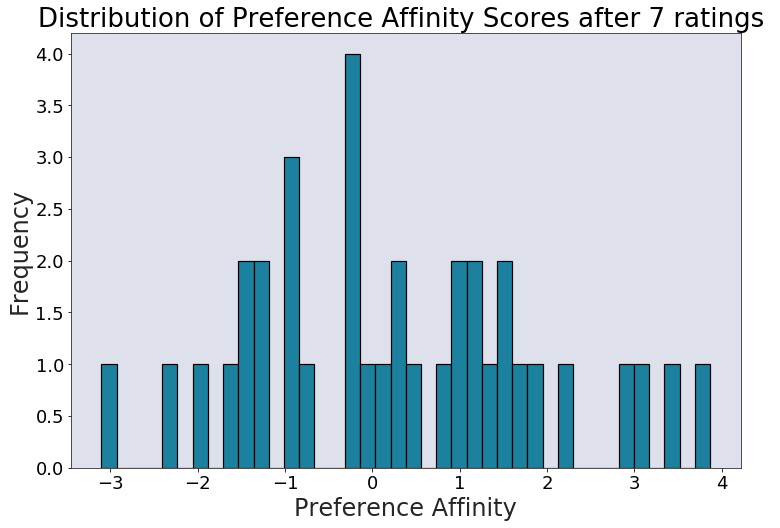

In [383]:
plt.hist(author_df['pref_aff'], bins=40, color='#1c819e', edgecolor='black', linewidth=1.2)
plt.xlabel('Preference Affinity')
plt.ylabel('Frequency')
plt.title("Distribution of Preference Affinity Scores after 7 ratings ")
plt.show()

In [384]:
### get list of films to update--only ratings from authors with positive preference affinity values
update_df = pd.read_sql_query('''
                SELECT * 
                FROM review INNER JOIN author USING(author_id) INNER JOIN film USING(film_id)
                WHERE pref_aff > 0
                GROUP BY film_id''', conn)
#set index to film_ids
update_df.set_index('film_id', inplace=True, drop=False)
#create tribe rating column
update_df['tribe_rating'] = None
### calc tribe ratings 
for x in update_df['film_id']:
    ##get by film reviews for each tribe member
    temp_df = \
    pd.read_sql_query("""
                      SELECT *
                      FROM review INNER JOIN author USING(author_id) INNER JOIN film USING(film_id)
                      WHERE film_id=? AND pref_aff > 0
                      """, conn, params=[x]) 
    ### normalize pref_aff weights to sum to number of tribe members
    normer = len(temp_df)/sum(temp_df['pref_aff'])
    temp_df['n_pref_aff']= normer * temp_df['pref_aff']
    tribe_rating = sum(temp_df['rating'] * temp_df['n_pref_aff'])/sum(temp_df['n_pref_aff'])
    update_df.loc[x, 'tribe_rating'] = tribe_rating

Let's inspect the updated tribal ratings after all 7 of my aunt's film ratings have been accounted for.

In [387]:
pd.set_option('display.max_rows', 2000)
update_df.loc[:,['film_title', 'film_release_date', 'film_rating_avg', 'tribe_rating']].sort_values(by="tribe_rating", ascending=False)

,film_title,film_release_date,film_rating_avg,tribe_rating
film_id,,,,
4076,Pan's Labyrinth,2006-12-29,95.864865,100
408,Ran,1985-12-20,95.150000,100
1,Star Wars: Episode V - The Empire Strikes Back,1980-05-21,83.090909,100
547,No Way Out,1987-08-14,79.000000,100
156,The Year of Living Dangerously,1983-01-21,70.000000,100
7512,Manchester by the Sea,2016-11-18,94.980392,100
160,Tex,1982-07-30,78.000000,100
6767,The Equalizer,2014-09-26,59.341463,100
165,Personal Best,1982-02-05,74.300000,100


One final way to look at the data is to sort based on the biggest differences between the wisdom-of-the-crowd ratings (aggregated based on all reviews) and the wisdom-of-the-tribe ratings. This gets at the heart of this project, which is to identify films rating predictions that change when the similarity of preferences between reviewers and a given user are accounted for. 

In [396]:
update_df['rating_diff'] = update_df['tribe_rating']-update_df['film_rating_avg']
update_df.loc[:,['film_title', 'film_release_date', 'film_rating_avg', 'tribe_rating', 'rating_diff']].sort_values(by=['tribe_rating', 'rating_diff'], ascending=False)

,film_title,film_release_date,film_rating_avg,tribe_rating,rating_diff
film_id,,,,,
408,Ran,1985-12-20,95.150000,100,4.85
4076,Pan's Labyrinth,2006-12-29,95.864865,100,4.13514
5078,Knowing,2009-03-20,45.592593,100,54.4074
141,Pink Floyd: The Wall,1982-08-06,50.888889,100,49.1111
356,Pale Rider,1985-06-28,57.800000,100,42.2
6767,The Equalizer,2014-09-26,59.341463,100,40.6585
291,Moscow on the Hudson,1984-04-06,61.428571,100,38.5714
133,TRON,1982-07-09,63.000000,100,37
262,Indiana Jones and the Temple of Doom,1984-05-23,63.000000,100,37
